<a href="https://colab.research.google.com/github/swampxx/sciann-examples/blob/main/sciann_1d_curve_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install sciann
%%capture sciann_installation
!pip install sciann

In [ ]:
# Module imports

import numpy as np
import matplotlib.pyplot as plt

import sciann as sn

%matplotlib inline

---------------------- SCIANN 0.6.3.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 


 Consider $f(x)=sin(x)$ function over the domain $x\rightarrow [0, 2\pi]$. 
 
 We can generate a set of discrete data by using $f$ to conduct simple experiment on SciANN.

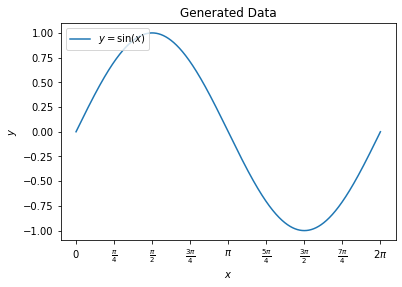

In [ ]:
x_train = np.linspace(0, np.pi*2, 5000)
y_train = np.sin(x_train)

# plot the data
plt.title('Generated Data')
plt.xlabel('$x$')
plt.ylabel('$y$')
xx = [idx*np.pi/4 for idx in range(9)]
xx_t = ['$0$', '$\\frac{\\pi}{4}$', '$\\frac{\\pi}{2}$', '$\\frac{3\\pi}{4}$', '$\\pi$', 
        '$\\frac{5\\pi}{4}$', '$\\frac{3\\pi}{2}$', '$\\frac{7\\pi}{4}$', '$2\\pi$']
plt.xticks(xx, xx_t)
plt.plot(x_train, y_train, label='$y = \sin (x)$')
plt.legend(loc="upper left")

plt.show()

Now, we can start to construct our model by starting.

We have input $x$ and output ${f}(x)= y =\sin(x)$. 
We use _Variable_ class to define our input layer and _Functional_ class to create the network.

In [ ]:
# Input
x = sn.Variable('x')

# Network
f_hat = sn.Functional(
    'f_hat',
    variables=x,
    hidden_layers=[8, 16, 8],
    activation='tanh'
)

We have created our input layer and the underlying network. Now, we need to enforce some constraints. 


First, we have data constraint. Output of the network $\hat{f}(x)$ should match with the $\sin(x)$

In [ ]:
constraint_data = sn.constraints.Data(f_hat)

Second, we know that second derivative of $\sin(x)$ is $-\sin(x)$ and their sum is zero. Therefore, our network $\hat{f}$ should satisy this condition as well.

We can enforce this by using PDE constraint.

In [ ]:
# diff(f, x, order=2) + y should be zero, 
#     while training zero labels will be used.
constraint_pde = sn.constraints.PDE(sn.utils.diff(f_hat, x, order=2) + f_hat)

SciModel is ready to be constructed!

Mean Squared Error is used for loss function.

ADAM with default values is used for optimizer. (lr=0.001, beta=(0.9, 0.999))

_Limitation: We can not employ weighting for the constraints. It is not supported!_

In [ ]:
model = sn.SciModel(x, [constraint_data, constraint_pde],
                    loss_func='mse',
                    optimizer='adam',
                    plot_to_file='network.png')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
D8b (Dense)                     (None, 8)            16          x[0][0]                          
__________________________________________________________________________________________________
sci_activation (SciActivation)  (None, 8)            0           D8b[0][0]                        
__________________________________________________________________________________________________
D16b (Dense)                    (None, 16)           144         sci_activation[0][0]             
______________________________________________________________________________________________

SciModel is constructed and it should be trained with the data we created in the beginning and the PDE constraint on network $f$.

In [ ]:
training_history = model.train(x_train,             # input x
                               [y_train, 'zeros'],  # y_train for data constraint, zeros for PDE constraint
                               batch_size = 32,
                               epochs=100)


Total samples: 5000 
Batch size: 32 
Total batches: 157 

Epoch 1/100
157/157 [==============================] - 1s 2ms/step - batch: 78.0000 - size: 31.8471 - loss: 0.3204 - f_hat_loss: 0.2708 - add_loss: 0.0496 - lr: 0.0010 - time: 1.2460
Epoch 2/100
157/157 [==============================] - 0s 2ms/step - batch: 78.0000 - size: 31.8471 - loss: 0.2052 - f_hat_loss: 0.1318 - add_loss: 0.0733 - lr: 0.0010 - time: 0.4122
Epoch 3/100
157/157 [==============================] - 0s 2ms/step - batch: 78.0000 - size: 31.8471 - loss: 0.1714 - f_hat_loss: 0.0964 - add_loss: 0.0750 - lr: 0.0010 - time: 0.4234
Epoch 4/100
157/157 [==============================] - 0s 2ms/step - batch: 78.0000 - size: 31.8471 - loss: 0.1598 - f_hat_loss: 0.0841 - add_loss: 0.0758 - lr: 0.0010 - time: 0.4317
Epoch 5/100
157/157 [==============================] - 0s 2ms/step - batch: 78.0000 - size: 31.8471 - loss: 0.1488 - f_hat_loss: 0.0763 - add_loss: 0.0725 - lr: 0.0010 - time: 0.4100
Epoch 6/100
157/157 [=====

We have trained our SciModel with Data and PDE constraints. In this section, we plot Loss vs. Epoch values to make some observations about the training procedure.

Please note that, all of the Keras functionalities are inherited. We can replace or customize our loss functions and optimizers by using Keras backend.

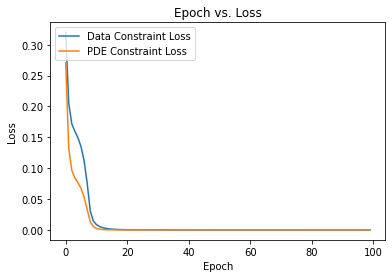

In [ ]:
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['f_hat_loss'])
plt.title('Epoch vs. Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Data Constraint Loss', 'PDE Constraint Loss'], loc='upper left')
plt.show()

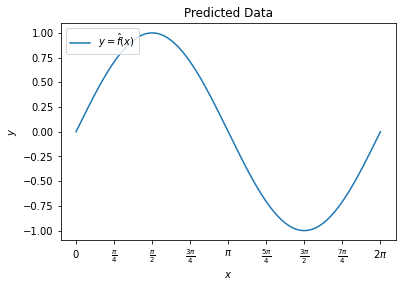

In [ ]:
y_pred = f_hat.eval(model, x_train)

# plot the data
plt.title('Predicted Data')
plt.xlabel('$x$')
plt.ylabel('$y$')
xx = [idx*np.pi/4 for idx in range(9)]
xx_t = ['$0$', '$\\frac{\\pi}{4}$', '$\\frac{\\pi}{2}$', '$\\frac{3\\pi}{4}$', '$\\pi$', 
        '$\\frac{5\\pi}{4}$', '$\\frac{3\\pi}{2}$', '$\\frac{7\\pi}{4}$', '$2\\pi$']
plt.xticks(xx, xx_t)
plt.plot(x_train, y_pred, label='$y=\hat{f}(x)$')
plt.legend(loc="upper left")

plt.show()